# "Bayesian Parameter Estimation"
> "We follow Chapters 2 and 3 of Sivia and Skilling's book to illustrate a simple Bayesian Parameter Estimation workflow"

- toc:true
- branch: master
- badges: true
- comments: true
- author: John J. Molina
- categories: [Data Analysis, Parameter Estimation]

In [1]:
import jax.numpy as np
import numpy.random as random
import matplotlib as mpl
import matplotlib.pyplot as plt
import pymc3 as pm
import theano
import theano.tensor as tt
from scipy.optimize import minimize
from jax import grad, jit, vmap, jacfwd, jacrev
from jax.config import config; config.update("jax_enable_x64", True)

mpl.style.use(['seaborn-poster', 'seaborn-muted'])

color = {'light':"#DCBCBC",
         'light_highlight':"#C79999",
         'mid':"#B97C7C", 
         'mid_highlight':"#A25050", 
         'dark':"#8F2727", 
         'dark_highlight':"#7C0000", 
         'light_trans':"#DCBCBC20", 
         'dark_trans':"#8F272720", 
         'superfine':"#00000060"}

def hessian(fun):
    return jit(jacfwd(jacrev(fun)))

def plot_quantiles(ax, x, data):
    """Plot quantiles of data as a function of x
       Note : q-th quantile of 'data' is the value 'q' away from the minimum to the maximum in a sorted copy of 'data'"""
    quantiles = np.quantile(data, np.arange(0.1, 1.0, 0.1), axis=0) # [0.1, ..., 0.9] -> 80% credible interval
    for i,c in zip(range(len(quantiles)//2), [color['light'], color['light_highlight'], color['mid'], color['mid_highlight']]):
        ax.fill_between(x, quantiles[i,:], quantiles[-(i+1),:], color=c)
    ax.plot(x, quantiles[4], color=color['dark'], lw=4)

In [2]:
def linear_func(θ, x):
    return θ[0] + θ[1]*x             # y = mx + b

def quadratic_func(θ, x):
    return θ[0] + θ[1]*x + θ[2]*x**2 # y = a x^2 + bx + c

def make_noisy_func(f, σ):
    """Returns function that computes noisy measurements for y ~ N(f, σ^2)"""
    return lambda θ,x : f(θ,x) + σ*random.randn(len(x))

/opt/anaconda3/envs/ML/lib/python3.7/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


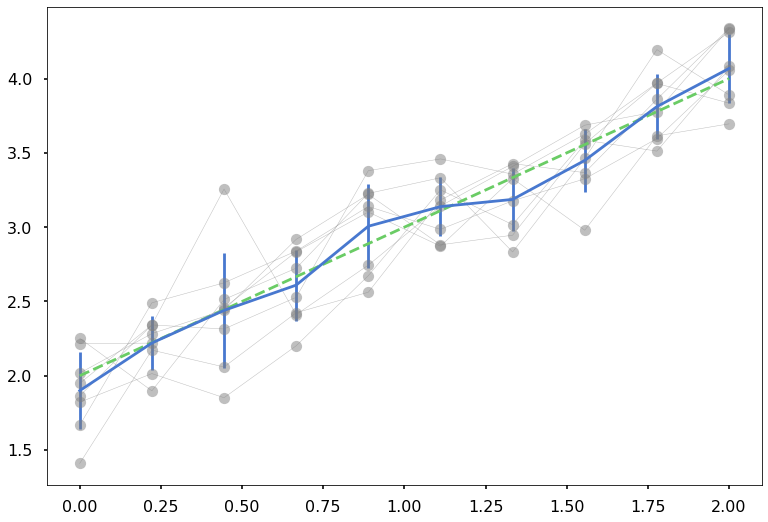

In [3]:
random.seed(12345)

_θ0,σ0        = np.array([2.0, 1.0, 0.6]), 0.25
#nparams,func = 3, quadratic_func
nparams,func  = 2, linear_func
θ0            = _θ0[:nparams]

measurement  = make_noisy_func(func, σ0)
npoints    = 10
x_sample    = np.linspace(0, 2.0, num=npoints)
y_sample    = np.array([measurement(θ0,x_sample) for i in range(8)])
y_avg, y_err= np.average(y_sample, axis=0), np.std(y_sample, axis=0)

fig, ax     = plt.subplots()
for yi in y_sample:
    ax.plot(x_sample, yi, marker='o', ls='None', alpha=0.5, color='Grey')
    ax.plot(x_sample, yi, lw=0.5, alpha=0.5, color='Grey')
ax.errorbar(x_sample, y_avg, yerr=y_err)
ax.plot(x_sample, func(θ0,x_sample), ls='--')
plt.show()

In [4]:
@jit
def chi2(θ):
    return np.sum((y_avg-func(θ,x_sample))**2/y_err**2)
grad_chi2  = jit(grad(chi2))
hess_chi2  = hessian(chi2)

In [5]:
opt       = minimize(chi2, np.ones_like(θ0), method='BFGS', jac=grad_chi2, options={'maxiter':100, 'disp':1})
opt_ihess = np.linalg.inv(hess_chi2(opt['x']))

Optimization terminated successfully.
         Current function value: 1.118355
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7


In [6]:
labels = ['b', 'm']
for i in range(nparams):
    avg, sigma, sigma_jax = opt['x'][i], np.sqrt(opt['hess_inv'][i,i]*2), np.sqrt(opt_ihess[i,i]*2)
    print(f'{avg-2*sigma:.2f} < θ_{i} < {avg+2*sigma:.2f} [μ = {avg:.2f}, σ = {sigma:.2f}]')

1.69 < θ_0 < 2.24 [μ = 1.96, σ = 0.14]
0.79 < θ_1 < 1.24 [μ = 1.02, σ = 0.11]


In [7]:
with pm.Model() as model_uni:
    #priors for unknown model parameters
    m = pm.Uniform('m', lower=-10, upper=10)
    b = pm.Uniform('b', lower=-10, upper=10)
    y = pm.Deterministic('y', func([b,m], x_sample))
    yobs = pm.Normal('yobs', mu=y, sd=y_err, observed=y_avg)
    
    prior_uni = pm.sample_prior_predictive(samples=1000, random_seed = 123456)
    trace_uni =  pm.sample(5000, tune = 20000, progressbar=True)
post_uni = pm.sample_posterior_predictive(trace_uni, model=model_uni, random_seed=4938483)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, m]
INFO:pymc3:NUTS: [b, m]
Sampling 2 chains, 0 divergences: 100%|██████████| 50000/50000 [00:24<00:00, 2017.80draws/s]
The acceptance probability does not match the target. It is 0.9123745676059328, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 10000/10000 [00:08<00:00, 1133.07it/s]


(0.0, 2.0)

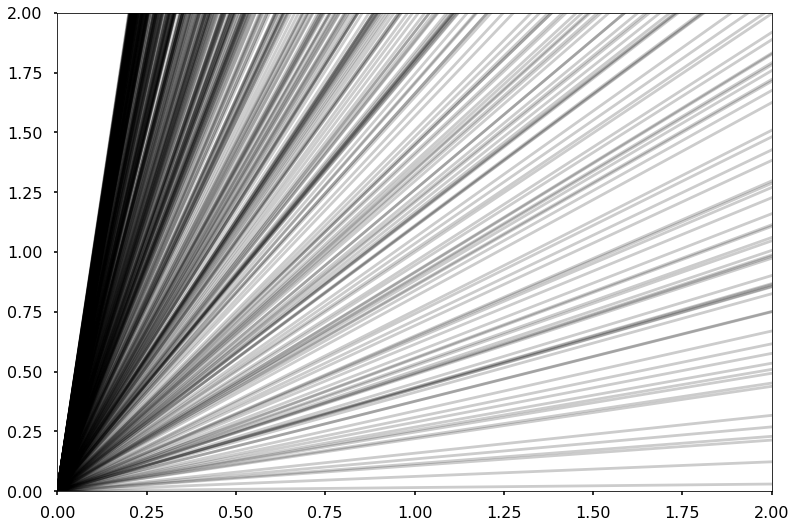

In [8]:
fig, ax = plt.subplots()
for y_i,b_i in zip(prior_uni['y'], prior_uni['b']):
    ax.plot(x_sample, y_i-b_i, alpha=0.2, color='k')
ax.set_ylim(0,2)
ax.set_xlim(0,2)

<Figure size 864x864 with 0 Axes>

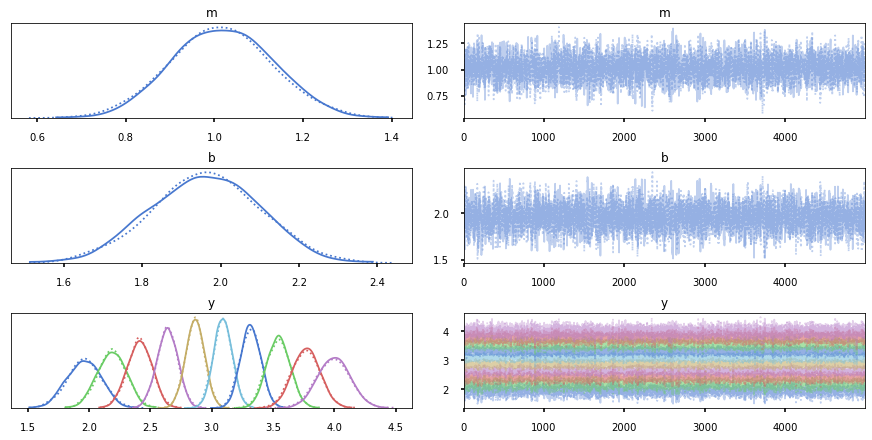

In [9]:
plt.figure(figsize=(12,12))
pm.traceplot(trace_uni)
plt.show();

<Figure size 504x504 with 0 Axes>

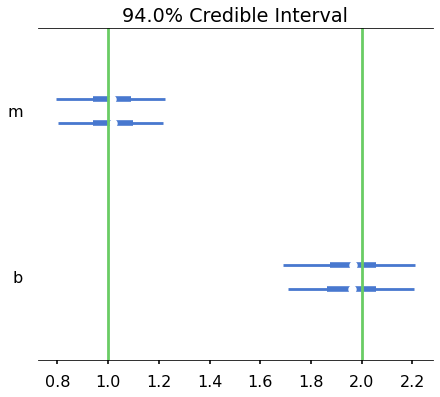

In [10]:
fig = plt.figure(figsize=(7,7))
pm.forestplot(trace_uni, var_names=['m', 'b']);
plt.axvline(1, 0, 1, c='C1')
plt.axvline(2, 0, 1, c='C1')
plt.show()

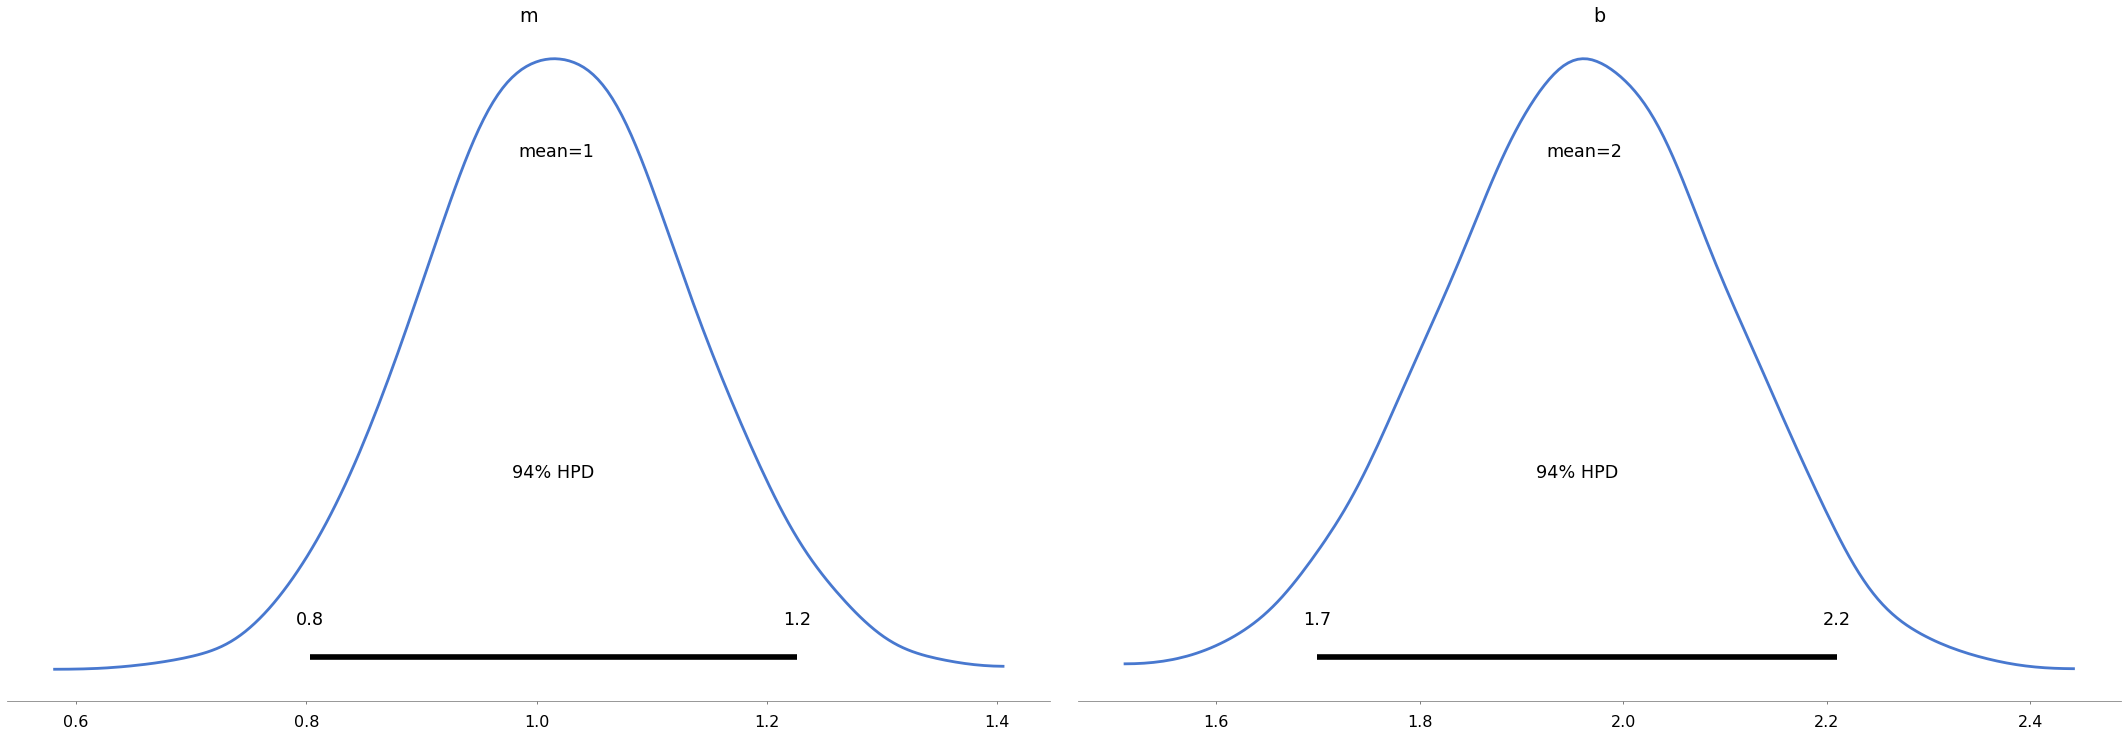

In [11]:
pm.plot_posterior(trace_uni, var_names=['m', 'b']);

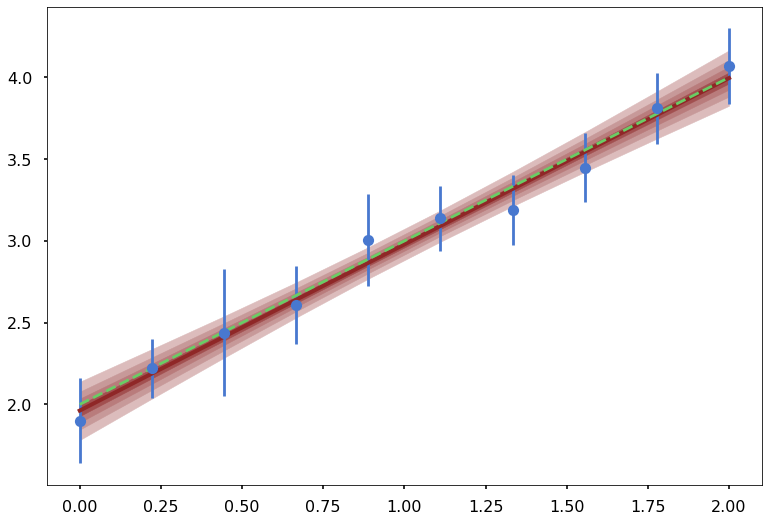

In [12]:
fig, ax = plt.subplots()
plot_quantiles(ax, x_sample, trace_uni['y'])
ax.errorbar(x_sample, y_avg, yerr=y_err, ls='None', marker='o')
ax.plot(x_sample, func(θ0,x_sample), ls='--')

In [13]:
with pm.Model() as model:
    #priors for unknown model parameters
    ϕ = pm.Uniform('ϕ', lower=-np.pi/2, upper=np.pi/2)
    m = pm.Deterministic('m', tt.tan(ϕ))
    a = pm.Uniform('a', lower=-10, upper=10)
    b = pm.Deterministic('b', a/tt.cos(ϕ))
    y = pm.Deterministic('y', func([b,m], x_sample))
    yobs = pm.Normal('yobs', mu=y, sd=y_err, observed=y_avg)
    
    prior = pm.sample_prior_predictive(samples=1000, random_seed = 123456)
    trace = pm.sample(10000, tune = 25000, progressbar=True)
post = pm.sample_posterior_predictive(trace, model=model, random_seed=4938483)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, ϕ]
INFO:pymc3:NUTS: [a, ϕ]
Sampling 2 chains, 0 divergences: 100%|██████████| 70000/70000 [00:42<00:00, 1666.21draws/s]
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 20000/20000 [00:14<00:00, 1381.64it/s]


<Figure size 864x864 with 0 Axes>

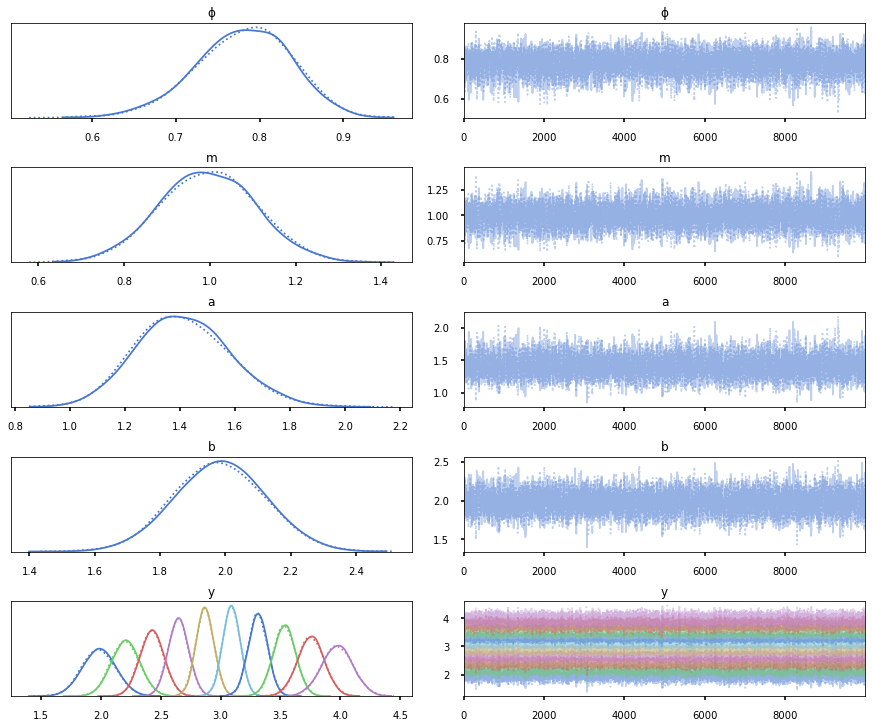

In [14]:
plt.figure(figsize=(12,12))
pm.traceplot(trace)
plt.show();

<Figure size 504x504 with 0 Axes>

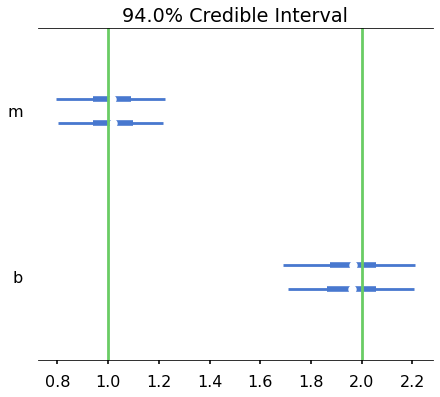

In [15]:
fig = plt.figure(figsize=(7,7))
pm.forestplot(trace_uni, var_names=['m', 'b']);
plt.axvline(1, 0, 1, c='C1')
plt.axvline(2, 0, 1, c='C1')
plt.show()

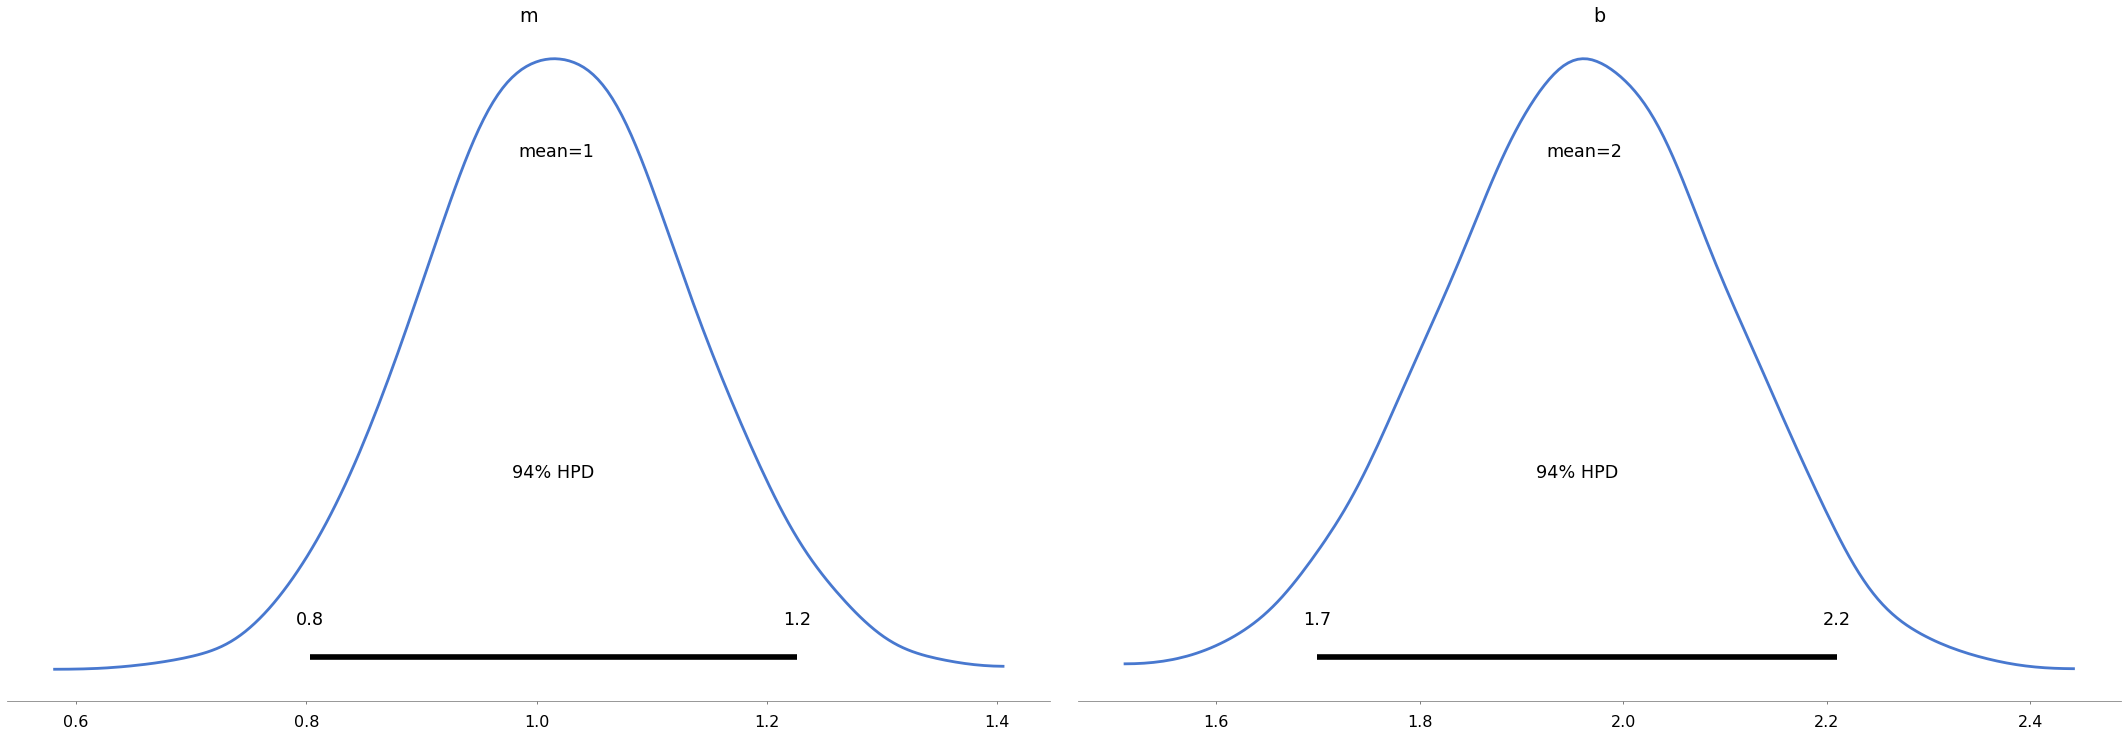

In [16]:
pm.plot_posterior(trace_uni, var_names=['m', 'b']);

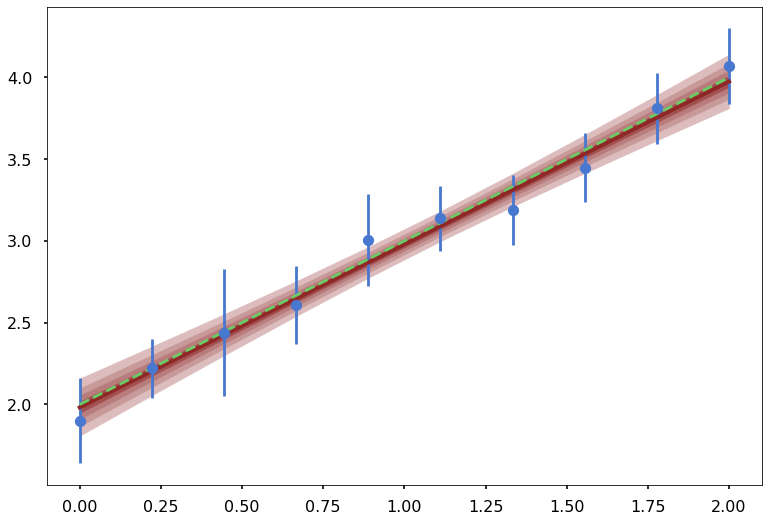

In [17]:
fig, ax = plt.subplots()
plot_quantiles(ax, x_sample, trace['y'])
ax.errorbar(x_sample, y_avg, yerr=y_err, ls='None', marker='o')
ax.plot(x_sample, func(θ0,x_sample), ls='--')

In [18]:
with pm.Model() as model_sig:
    #priors for unknown model parameters
    m = pm.Uniform('m', lower=-10, upper=10)
    b = pm.Uniform('b', lower=-10, upper=10)
    logσ = pm.Uniform('logσ', lower=-6, upper=6)
    σ    = pm.Deterministic('σ', tt.exp(logσ))
    y = pm.Deterministic('y', func([b,m], x_sample))
    yobs = pm.Normal('yobs', mu=y, sd=σ, observed=y_sample[0])
    
    prior_sig = pm.sample_prior_predictive(samples=1000, random_seed = 123456)
    trace_sig =  pm.sample(5000, tune = 50000, progressbar=True)
#post_sig = pm.sample_posterior_predictive(trace_uni, model=model_sig, random_seed=4938483)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logσ, b, m]
INFO:pymc3:NUTS: [logσ, b, m]
Sampling 2 chains, 0 divergences: 100%|██████████| 110000/110000 [01:07<00:00, 1636.44draws/s]


<Figure size 864x864 with 0 Axes>

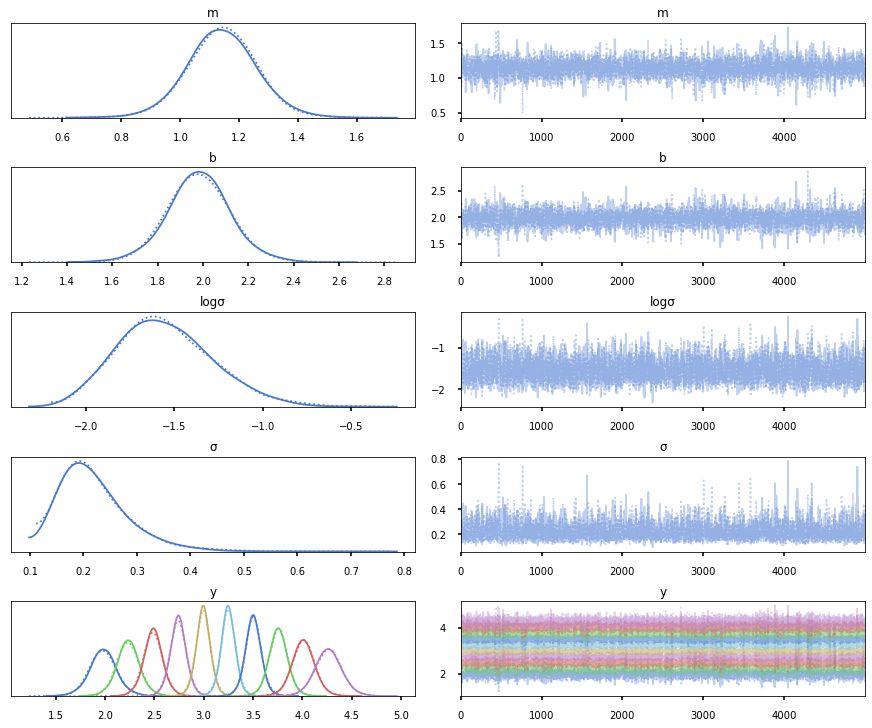

In [19]:
plt.figure(figsize=(12,12))
pm.traceplot(trace_sig)
plt.show();

<Figure size 504x504 with 0 Axes>

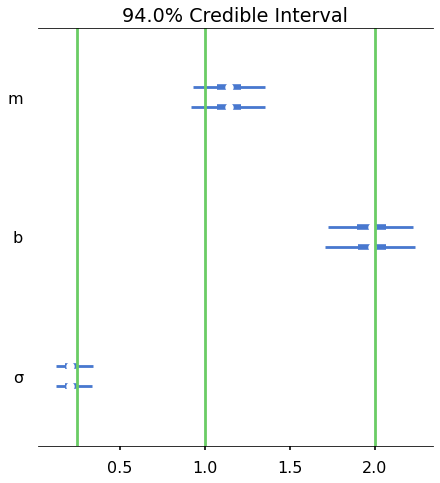

In [20]:
fig = plt.figure(figsize=(7,7))
pm.forestplot(trace_sig, var_names=['m', 'b', 'σ']);
plt.axvline(1, 0, 1, c='C1')
plt.axvline(2, 0, 1, c='C1')
plt.axvline(σ0, 0, 1, c='C1')
plt.show()

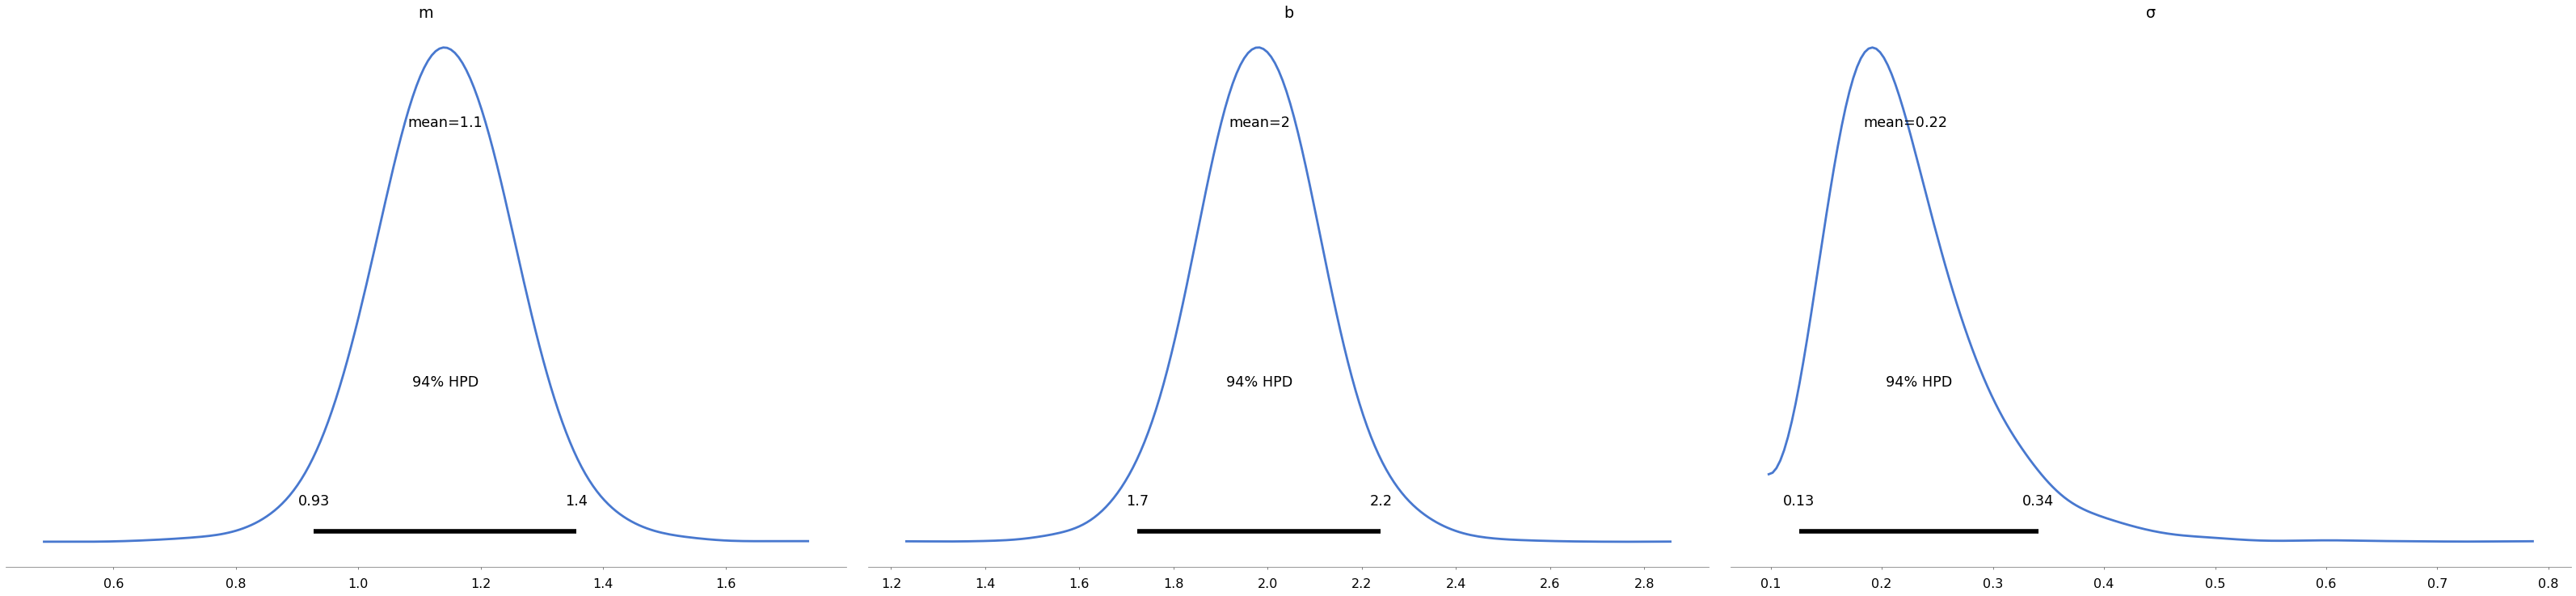

In [21]:
pm.plot_posterior(trace_sig, var_names=['m', 'b', 'σ']);

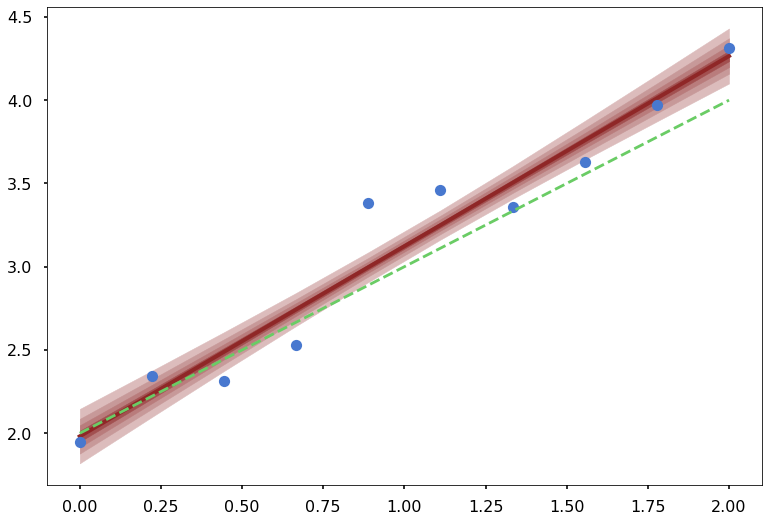

In [22]:
fig, ax = plt.subplots()
plot_quantiles(ax, x_sample, trace_sig['y'])
ax.plot(x_sample, y_sample[0], ls='None', marker='o')
ax.plot(x_sample, func(θ0,x_sample), ls='--')

In [23]:
@jit
def loss(θ):
    return np.sum((y_sample[0]-func(θ,x_sample))**2)
grad_loss  = jit(grad(loss))
hess_loss  = hessian(loss)

In [24]:
opt       = minimize(loss, np.ones_like(θ0), method='BFGS', jac=grad_loss, options={'maxiter':100, 'disp':1})
opt_ihess = np.linalg.inv(hess_loss(opt['x']))

Optimization terminated successfully.
         Current function value: 0.323150
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6


In [26]:
S0    = loss(opt['x'])
σopt  = np.sqrt(S0/(npoints + 1 - nparams))
dσopt = σopt / np.sqrt(2*(npoints + 1 - nparams))
print(f'{σopt - 2*dσopt:.3f} < σ < {σopt + 2*dσopt:.3f} (μ_σ = {σopt:.3f}, σ_σ={dσopt:.3f})')

0.100 < σ < 0.279 (μ_σ = 0.189, σ_σ=0.045)
